# Training a QMPS agent

This notebook demonstrates how to train a QMPS agent on different initial states.

In [11]:
import os
import sys
import time
import random
import pickle
import itertools
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import dqn_utils
import dqn
sys.path.append('../environment/')
import env as environment

In [3]:
# directory where all results are saved
save_name = "test/"

# fix random seed
seed = 30
np.random.seed(seed)
random.seed(seed)

## 1. Fix parameters

We first need to define the control problem and fix all hyperparameters of the optimization.

### Setting up the RL environment

Below we define the (hyper)parameters of the RL environment, i.e., the spin chain to be controlled.

In [4]:
# important parameters (determines name of folder results are saved to)
env_params = dict(
    L = 4, # system size
    n_time_steps = 50, # maximum number of allowed protocol steps
    n_actions = 12, # action set size
    delta_t = 6, # time step size is: 0.5 * np.pi/delta_t, 0.5 * np.pi/(delta_t + 2.5)
    threshold = 0.005 # reward threshold
)

# additional environment parameters
D = 4 # quantum state bond dim
full_env_params = dict(
    initial_state_params = dict(J=1.0, gx=1.0, gz=0.0), # initial ground state parameters
    final_state_params = dict(J=0.0, gx=0.0, gz=1.0), # target ground state parameters
    seed=seed,
    D=D,
    random_initial_state=True, # whether to start from fixed or randomly sampled initial states
    sample_states=None, # precomputed initial states
    init_ents=None, # precomputed initial state entropies
    continue_train = None, # multi-stage training
    reward_function=environment.RewardFunction.LogFidelity,
    random_init_state = environment.InitialState.GroundState,
)
full_env_params.update(env_params)
env = environment.SpinChainEnv(**full_env_params)

Default device:  TFRT_CPU_0
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.758769989013672+0j)    

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4+0j)    30511475+0j)    



### Setting up the QMPS agent

Below we define the (hyper)parameters of the QMPS agent.

In [5]:
batch_size = 64 # batch size
agent_params = dict(
    tn = 'mps', # tn architecture: mps or mpo
    nn = True, # whether to also use a neural network
    learning_rate = 1e-4,
    gamma = 0.98, # RL discount factor
    buffer_size = 8000, # Replay buffer size
    n_feat = 32, # MPS output dimension (feature dimension)
    hidden_dim = 100, # NN hidden layer dimension
    uniform = False, # whether MPS bond dimension is uniform or exponentially increasing
    D = 4, # MPS bond dimension
    seed = seed,
)

initial_params = None
agent = dqn.DQNAgent(env, batch_size=batch_size, std=0.5, scale = 1.0, factor = 1.0, **agent_params)

Use NN:  True
Default platform:  cpu
NN layer dimensions:  [32, 100, 100, 12]
QMPS tensor dimensions:  [(1, 2, 2), (2, 2, 4), (4, 32, 4), (4, 2, 2), (2, 2, 1)]


### Defining training parameters

Below we define some additional training hyperparameters.

In [6]:
training_params = dict(
n_episodes = 4000, # number of training episodes
batch_size = batch_size,
eps_init = 1.0, # initial RL epsilon (action selection)
eps_final = 0.01, # final RL epsilon parameter
eps_decay = 1.0, # determines slope of exponentially decaying curve
target_update = 10, # target network update frequency
update_frequency = 1, # optimization frequency (compared to environment steps)
)

## 2. Bookkeeping

For reproducibility reasons, we define unique directory/filenames for the results.

In [7]:
# environment parameters determine dir name
dir_name = "../results/" + save_name
dir_name = dir_name + "".join("{}_".format(val) for key, val in env_params.items()) + "/"

# save script for reproducability
dir_name2 = dir_name+"_scripts"
os.makedirs(dir_name2, exist_ok=True)
print("Results saved to: ", dir_name)

# agent and training parameters determine file names
str1 = "".join("{}{}_".format(key, val) for key, val in training_params.items()) + "D%s_" %(D)
str2 = "".join("{}{}_".format(key, val) for key, val in agent_params.items())
save_model = dir_name + "model_" + str1 + str2
training_params['eps_decay'] = training_params['n_episodes'] / (training_params['eps_decay'] * 8)
print("\nRunning: ", str1 + str2)

Results saved to:  ../results/test/4_50_12_6_0.005_/

Running:  n_episodes4000_batch_size64_eps_init1.0_eps_final0.01_eps_decay1.0_target_update10_update_frequency1_D4_tnmps_nnTrue_learning_rate0.0001_gamma0.98_buffer_size8000_n_feat32_hidden_dim100_uniformFalse_D4_seed30_


## 3. Training

Now we can finally train the QMPS agent.

The `train` function returns:
* list of final episode rewards
* list of (decaying) epsilon parameter (used for action selection)
* list of DQN regression loss values during training
* list of quantum state MPS bond truncation error during training
* list of quantum state MPS half-chain von Neumann entropies during training
* list of number of episode steps
* list of returns (summed up rewards)


The cell below might take a bit to run (~10 mins).

In [8]:
start_time = time.time()
episode_rewards, epsilon, losses, trunc_errs, entropies, episode_steps, returns = dqn_utils.train(
    env, agent, **training_params, save_model=save_model)
exec_time = time.time() - start_time
print("DONE: --- {:.4f} seconds ---".format(exec_time))

TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.935468673706055+0j)     

two site
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.853073596954346+0j)     

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.768510818481445+0j)     

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.973508834838867+0j)    

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.827136039733887+0j)     

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.842608451843262+0j)    

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.888586044311523+0j)     

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.969498157501221+0j)     

TS-DMRG sweep=16/200, sites=(0,1)/4: optimized E=(-5.085718154907227+0j)    

TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.909811973571777+0j)     

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.087291717529297+0j)    

TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.086983680725098+0j)     

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.83782

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.034640312194824+0j)    

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.821779727935791+0j)     

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.9481916427612305+0j)    

TS-DMRG sweep=13/200, sites=(0,1)/4: optimized E=(-4.914677143096924+0j)    

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.805174827575684+0j)    

TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.897853851318359+0j)    

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.080312252044678+0j)     

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.883144378662109+0j)    

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.0085906982421875+0j)    

TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.009064674377441+0j)    

TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-5.012078285217285+0j)    

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.959745407104492+0j)    

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.056630611419678+0

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.843034744262695+0j)    


Final reward 26: -0.443485
Number steps 26: 49
Elapsed time: 0.1884
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.012110710144043+0j)    


Final reward 27: -0.572290
Number steps 27: 49
Elapsed time: 0.2094
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.008280277252197+0j)     


Final reward 28: -0.449491
Number steps 28: 49
Elapsed time: 0.1826
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.9912567138671875+0j)    


Final reward 29: -0.274214
Number steps 29: 49
Elapsed time: 0.1801
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.946300983428955+0j)     


Final reward 30: -0.698260
Number steps 30: 49
Elapsed time: 0.1766
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.922338008880615+0j)    


Final reward 31: -0.902347
Number steps 31: 49
Elapsed time: 0.3206
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.079139232635498+0j)    


Final reward 32: -0.359181
Number steps 32

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.992119789123535+0j)    


Final reward 82: -0.714781
Number steps 82: 49
Elapsed time: 0.2149
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.885379314422607+0j)    


Final reward 83: -0.494416
Number steps 83: 49
Elapsed time: 0.3266
TS-DMRG sweep=16/200, sites=(0,1)/4: optimized E=(-4.903425216674805+0j)     


Final reward 84: -1.494000
Number steps 84: 49
Elapsed time: 0.4318
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.869316577911377+0j)     


Final reward 85: -0.674416
Number steps 85: 49
Elapsed time: 0.2469
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.970738410949707+0j)    


Final reward 86: -2.060206
Number steps 86: 49
Elapsed time: 0.2579
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.947364330291748+0j)     


Final reward 87: -0.616532
Number steps 87: 49
Elapsed time: 0.2485
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.907828330993652+0j)     


Final reward 88: -0.792016
Number steps 8

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.987562656402588+0j)     


Final reward 137: -0.346303
Number steps 137: 49
Elapsed time: 0.2731
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.022095680236816+0j)    


Final reward 138: -0.903071
Number steps 138: 49
Elapsed time: 0.3225
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.835792541503906+0j)     


Final reward 139: -0.588025
Number steps 139: 49
Elapsed time: 0.1897
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.0332512855529785+0j)    


Final reward 140: -0.209342
Number steps 140: 49
Elapsed time: 0.1925
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.023194313049316+0j)    


Final reward 141: -0.210720
Number steps 141: 49
Elapsed time: 0.3088
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.058104515075684+0j)    


Final reward 142: -0.985997
Number steps 142: 49
Elapsed time: 0.1963
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.017905235290527+0j)     


Final reward 143: -0.194992


TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.887287616729736+0j)     


Final reward 192: -0.241216
Number steps 192: 49
Elapsed time: 0.3860
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.790209770202637+0j)     


Final reward 193: -0.144884
Number steps 193: 49
Elapsed time: 0.2016
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.882211208343506+0j)     


Final reward 194: -0.114796
Number steps 194: 49
Elapsed time: 0.1998
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.91185188293457+0j)      


Final reward 195: -0.317060
Number steps 195: 49
Elapsed time: 0.2420
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.903777599334717+0j)    


Final reward 196: -0.109242
Number steps 196: 49
Elapsed time: 0.2690
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.949775218963623+0j)     


Final reward 197: -0.227454
Number steps 197: 49
Elapsed time: 0.1928
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.839585781097412+0j)     


Final reward 198: -0.385857

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.8053436279296875+0j)    


Final reward 247: -0.220780
Number steps 247: 49
Elapsed time: 0.2028
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.863821983337402+0j)     


Final reward 248: -0.142330
Number steps 248: 49
Elapsed time: 0.2531
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.80935525894165+0j)     


Final reward 249: -0.142492
Number steps 249: 49
Elapsed time: 0.2054
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.019742965698242+0j)    


Final reward 250: -0.718886
Number steps 250: 49
Elapsed time: 0.2130
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.900907516479492+0j)     


Final reward 251: -0.466036
Number steps 251: 49
Elapsed time: 0.2585
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.084269046783447+0j)     


Final reward 252: -0.079346
Number steps 252: 49
Elapsed time: 0.1991
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.836294651031494+0j)     


Final reward 253: -0.119912
N

TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.077268600463867+0j)    


Final reward 302: -0.035636
Number steps 302: 49
Elapsed time: 0.2653
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.850592613220215+0j)    


Final reward 303: -0.166915
Number steps 303: 49
Elapsed time: 0.2373
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.022776126861572+0j)     


Final reward 304: -0.148645
Number steps 304: 49
Elapsed time: 0.2816
TS-DMRG sweep=16/200, sites=(0,1)/4: optimized E=(-4.989453315734863+0j)     


Final reward 305: -0.123185
Number steps 305: 49
Elapsed time: 0.4088
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.9196858406066895+0j)    


Final reward 306: -0.213551
Number steps 306: 49
Elapsed time: 0.2743
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.063478946685791+0j)     


Final reward 307: -0.314476
Number steps 307: 49
Elapsed time: 0.2047
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.021327018737793+0j)     


Final reward 308: -0.386889


TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.849513530731201+0j)    


Final reward 357: -0.261508
Number steps 357: 49
Elapsed time: 0.3013
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.993528366088867+0j)    


Final reward 358: -0.069009
Number steps 358: 49
Elapsed time: 0.2040
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.7616424560546875+0j)    


Final reward 359: -0.082520
Number steps 359: 49
Elapsed time: 0.2288
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.921957492828369+0j)     


Final reward 360: -0.112500
Number steps 360: 49
Elapsed time: 0.2133
TS-DMRG sweep=17/200, sites=(0,1)/4: optimized E=(-4.938998222351074+0j)    


Final reward 361: -0.093066
Number steps 361: 49
Elapsed time: 0.3985
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.78286075592041+0j)      


Final reward 362: -0.156415
Number steps 362: 49
Elapsed time: 0.1917
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.764553070068359+0j)    


Final reward 363: -0.109718
Nu

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.076470375061035+0j)    


Final reward 412: -0.168499
Number steps 412: 49
Elapsed time: 0.2174
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.042837142944336+0j)     


Final reward 413: -0.048238
Number steps 413: 49
Elapsed time: 0.2327
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.896853446960449+0j)    


Final reward 414: -0.174897
Number steps 414: 49
Elapsed time: 0.2034
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.820782661437988+0j)     


Final reward 415: -0.072895
Number steps 415: 49
Elapsed time: 0.1885
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.069469928741455+0j)     


Final reward 416: -0.193927
Number steps 416: 49
Elapsed time: 0.2558
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.989445686340332+0j)    


Final reward 417: -0.138330
Number steps 417: 49
Elapsed time: 0.2025
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.81963586807251+0j)     


Final reward 418: -0.035653
Num

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.072507381439209+0j)    


Final reward 467: -0.078887
Number steps 467: 49
Elapsed time: 0.2315
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.913302421569824+0j)    


Final reward 468: -0.134905
Number steps 468: 49
Elapsed time: 0.2117
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.860239028930664+0j)     


Final reward 469: -0.069780
Number steps 469: 49
Elapsed time: 0.2032
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.994518756866455+0j)     


Final reward 470: -0.141818
Number steps 470: 49
Elapsed time: 0.2335
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.7783098220825195+0j)    


Final reward 471: -0.165593
Number steps 471: 49
Elapsed time: 0.2381
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.835713863372803+0j)     


Final reward 472: -0.274137
Number steps 472: 49
Elapsed time: 0.2299
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.0073723793029785+0j)    


Final reward 473: -0.112564
N

TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.7838897705078125+0j)    


Final reward 522: -0.042973
Number steps 522: 49
Elapsed time: 0.3072
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.891866683959961+0j)     


Final reward 523: -0.067194
Number steps 523: 49
Elapsed time: 0.2797
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.998538494110107+0j)    


Final reward 524: -0.033969
Number steps 524: 49
Elapsed time: 0.2000
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.919932842254639+0j)     


Final reward 525: -0.042710
Number steps 525: 49
Elapsed time: 0.2245
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.892627716064453+0j)     


Final reward 526: -0.153842
Number steps 526: 49
Elapsed time: 0.2158
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.837318420410156+0j)     


Final reward 527: -0.120301
Number steps 527: 49
Elapsed time: 0.2921
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.050314903259277+0j)     


Final reward 528: -0.048237


TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.765670299530029+0j)     


Final reward 577: -0.143001
Number steps 577: 49
Elapsed time: 0.2170
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.805006504058838+0j)     


Final reward 578: -0.162073
Number steps 578: 49
Elapsed time: 0.2309
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.848930358886719+0j)     


Final reward 579: -0.036879
Number steps 579: 49
Elapsed time: 0.2249
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.979903221130371+0j)     


Final reward 580: -0.058684
Number steps 580: 49
Elapsed time: 0.3312
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.041385650634766+0j)    


Final reward 581: -0.058703
Number steps 581: 49
Elapsed time: 0.2234
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.998969554901123+0j)    


Final reward 582: -0.183812
Number steps 582: 49
Elapsed time: 0.3029
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.844013690948486+0j)     


Final reward 583: -0.038587


TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.957823753356934+0j)    


Final reward 632: -0.094234
Number steps 632: 49
Elapsed time: 0.3358
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.962409496307373+0j)    


Final reward 633: -0.063195
Number steps 633: 49
Elapsed time: 0.2055
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.044259071350098+0j)     


Final reward 634: -0.048263
Number steps 634: 49
Elapsed time: 0.2715
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.89023494720459+0j)     


Final reward 635: -0.039559
Number steps 635: 49
Elapsed time: 0.3920
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.901108741760254+0j)     


Final reward 636: -0.022386
Number steps 636: 49
Elapsed time: 0.2861
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.830322742462158+0j)    


Final reward 637: -0.025578
Number steps 637: 49
Elapsed time: 0.2437
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.862861156463623+0j)     


Final reward 638: -0.070470
N

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.816756725311279+0j)     


Final reward 687: -0.182716
Number steps 687: 49
Elapsed time: 0.2552
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.796796798706055+0j)     


Final reward 688: -0.058070
Number steps 688: 49
Elapsed time: 0.2625
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.95379114151001+0j)     


Final reward 689: -0.021323
Number steps 689: 49
Elapsed time: 0.2093
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.894079208374023+0j)    


Final reward 690: -0.042472
Number steps 690: 49
Elapsed time: 0.2105
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.088454246520996+0j)     


Final reward 691: -0.011043
Number steps 691: 49
Elapsed time: 0.2100
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.872734546661377+0j)     


Final reward 692: -0.041474
Number steps 692: 49
Elapsed time: 0.2295
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.9807000160217285+0j)    


Final reward 693: -0.027595


TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.856105804443359+0j)    


Final reward 742: -0.255272
Number steps 742: 49
Elapsed time: 0.2016
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.830511093139648+0j)    


Final reward 743: -0.037894
Number steps 743: 49
Elapsed time: 0.2267
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.998034477233887+0j)     


Final reward 744: -0.063267
Number steps 744: 49
Elapsed time: 0.3671
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.841134548187256+0j)     


Final reward 745: -0.022866
Number steps 745: 49
Elapsed time: 0.2851
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.086035251617432+0j)    


Final reward 746: -0.019794
Number steps 746: 49
Elapsed time: 0.2289
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.0054030418396+0j)      


Final reward 747: -0.017319
Number steps 747: 49
Elapsed time: 0.4227
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.0617828369140625+0j)    


Final reward 748: -0.065806
Nu

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.76792573928833+0j)      


Final reward 797: -0.037127
Number steps 797: 49
Elapsed time: 0.2170
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.07243537902832+0j)      


Final reward 798: -0.030616
Number steps 798: 49
Elapsed time: 0.2714
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.069350719451904+0j)     


Final reward 799: -0.049953
Number steps 799: 49
Elapsed time: 0.2872
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.796170234680176+0j)    


Final reward 800: -0.027279
Number steps 800: 49
Elapsed time: 0.2381
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.844959735870361+0j)     


Final reward 801: -0.018119
Number steps 801: 49
Elapsed time: 0.2241
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.8114013671875+0j)      


Final reward 802: -0.059034
Number steps 802: 49
Elapsed time: 0.2685
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.76954984664917+0j)      


Final reward 803: -0.020939
N

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.914097785949707+0j)    


Final reward 852: -0.004221
Number steps 852: 16
Elapsed time: 0.1017
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.029452800750732+0j)    


Final reward 853: -0.027105
Number steps 853: 49
Elapsed time: 0.2911
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.9997382164001465+0j)    


Final reward 854: -0.029258
Number steps 854: 49
Elapsed time: 0.2356
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.823668956756592+0j)    


Final reward 855: -0.011373
Number steps 855: 49
Elapsed time: 0.2270
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.9461259841918945+0j)    


Final reward 856: -0.044400
Number steps 856: 49
Elapsed time: 0.2020
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.858194828033447+0j)     


Final reward 857: -0.057542
Number steps 857: 49
Elapsed time: 0.2762
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.97381591796875+0j)     


Final reward 858: -0.017930
Nu

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.915953636169434+0j)    


Final reward 907: -0.020152
Number steps 907: 49
Elapsed time: 0.2190
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.789981365203857+0j)    


Final reward 908: -0.042212
Number steps 908: 49
Elapsed time: 0.2119
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.916528224945068+0j)    


Final reward 909: -0.029620
Number steps 909: 49
Elapsed time: 0.2404
TS-DMRG sweep=17/200, sites=(0,1)/4: optimized E=(-4.828561782836914+0j)     


Final reward 910: -0.027971
Number steps 910: 49
Elapsed time: 0.3942
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.976802825927734+0j)    


Final reward 911: -0.075727
Number steps 911: 49
Elapsed time: 0.1900
TS-DMRG sweep=14/200, sites=(0,1)/4: optimized E=(-4.900251865386963+0j)     


Final reward 912: -0.014243
Number steps 912: 49
Elapsed time: 0.3662
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.91123104095459+0j)     


Final reward 913: -0.028510
Nu

TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.041599750518799+0j)     


Final reward 962: -0.016807
Number steps 962: 49
Elapsed time: 0.2822
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.976555824279785+0j)    


Final reward 963: -0.059654
Number steps 963: 49
Elapsed time: 0.2098
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.00239372253418+0j)      


Final reward 964: -0.062124
Number steps 964: 49
Elapsed time: 0.2439
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.863700866699219+0j)     


Final reward 965: -0.026182
Number steps 965: 49
Elapsed time: 0.2317
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.788001537322998+0j)     


Final reward 966: -0.030736
Number steps 966: 49
Elapsed time: 0.2133
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.766107559204102+0j)    


Final reward 967: -0.035068
Number steps 967: 49
Elapsed time: 0.2595
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.028456687927246+0j)     


Final reward 968: -0.012216
N

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.77422571182251+0j)     


Final reward 1017: -0.027348
Number steps 1017: 49
Elapsed time: 0.1880
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.970114707946777+0j)     


Final reward 1018: -0.004538
Number steps 1018: 12
Elapsed time: 0.2477
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.92769718170166+0j)     


Final reward 1019: -0.036558
Number steps 1019: 49
Elapsed time: 0.2756
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.012796878814697+0j)     


Final reward 1020: -0.017639
Number steps 1020: 49
Elapsed time: 0.2012
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.950201511383057+0j)     


Final reward 1021: -0.036650
Number steps 1021: 49
Elapsed time: 0.2262
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.995336055755615+0j)    


Final reward 1022: -0.023595
Number steps 1022: 49
Elapsed time: 0.2208
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.796322822570801+0j)    


Final reward 1023:

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.899301052093506+0j)     


Final reward 1071: -0.016547
Number steps 1071: 49
Elapsed time: 0.2716
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.012783050537109+0j)    


Final reward 1072: -0.026440
Number steps 1072: 49
Elapsed time: 0.3077
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.984806060791016+0j)    


Final reward 1073: -0.012481
Number steps 1073: 49
Elapsed time: 0.2379
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.065598487854004+0j)     


Final reward 1074: -0.012305
Number steps 1074: 49
Elapsed time: 0.2778
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.980913162231445+0j)     


Final reward 1075: -0.025123
Number steps 1075: 49
Elapsed time: 0.1913
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.874795436859131+0j)     


Final reward 1076: -0.035463
Number steps 1076: 49
Elapsed time: 0.2396
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.760767936706543+0j)    


Final reward 1077:

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.889255046844482+0j)    


Final reward 1125: -0.022770
Number steps 1125: 49
Elapsed time: 0.2176
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.909704208374023+0j)    


Final reward 1126: -0.107843
Number steps 1126: 49
Elapsed time: 0.2320
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.887796878814697+0j)     


Final reward 1127: -0.016870
Number steps 1127: 49
Elapsed time: 0.3331
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.770683288574219+0j)     


Final reward 1128: -0.013018
Number steps 1128: 49
Elapsed time: 0.1955
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.945633888244629+0j)     


Final reward 1129: -0.065519
Number steps 1129: 49
Elapsed time: 0.1895
TS-DMRG sweep=13/200, sites=(0,1)/4: optimized E=(-4.775627613067627+0j)     


Final reward 1130: -0.020882
Number steps 1130: 49
Elapsed time: 0.3454
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.9184746742248535+0j)    


Final reward 11

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.919187545776367+0j)     


Final reward 1179: -0.019174
Number steps 1179: 49
Elapsed time: 0.2207
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.961503505706787+0j)     


Final reward 1180: -0.076648
Number steps 1180: 49
Elapsed time: 0.2878
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.899684429168701+0j)    


Final reward 1181: -0.024374
Number steps 1181: 49
Elapsed time: 0.3276
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.003384113311768+0j)    


Final reward 1182: -0.019186
Number steps 1182: 49
Elapsed time: 0.2089
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.881922721862793+0j)    


Final reward 1183: -0.015249
Number steps 1183: 49
Elapsed time: 0.2021
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.056157112121582+0j)     


Final reward 1184: -0.016881
Number steps 1184: 49
Elapsed time: 0.2705
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.9542131423950195+0j)    


Final reward 1185

TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.038569450378418+0j)    


Final reward 1233: -0.010864
Number steps 1233: 49
Elapsed time: 0.2631
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.8540496826171875+0j)    


Final reward 1234: -0.022330
Number steps 1234: 49
Elapsed time: 0.1955
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.851991653442383+0j)    


Final reward 1235: -0.018579
Number steps 1235: 49
Elapsed time: 0.2274
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.998776912689209+0j)    


Final reward 1236: -0.007441
Number steps 1236: 49
Elapsed time: 0.2008
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.922542572021484+0j)    


Final reward 1237: -0.012135
Number steps 1237: 49
Elapsed time: 0.3273
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.034145355224609+0j)    


Final reward 1238: -0.012378
Number steps 1238: 49
Elapsed time: 0.3103
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.063373565673828+0j)     


Final reward 1239:

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.061911106109619+0j)     


Final reward 1287: -0.024680
Number steps 1287: 49
Elapsed time: 0.2063
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.920714855194092+0j)    


Final reward 1288: -0.137065
Number steps 1288: 49
Elapsed time: 0.2681
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.762859344482422+0j)     


Final reward 1289: -0.021679
Number steps 1289: 49
Elapsed time: 0.3271
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.974153518676758+0j)    


Final reward 1290: -0.027180
Number steps 1290: 49
Elapsed time: 0.2992
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.0153021812438965+0j)    


Final reward 1291: -0.010792
Number steps 1291: 49
Elapsed time: 0.2070
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.8178791999816895+0j)    


Final reward 1292: -0.026328
Number steps 1292: 49
Elapsed time: 0.2221
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.77047872543335+0j)      


Final reward 12

TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.069011211395264+0j)     


Final reward 1341: -0.014521
Number steps 1341: 49
Elapsed time: 0.3125
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.996941566467285+0j)    


Final reward 1342: -0.009119
Number steps 1342: 49
Elapsed time: 0.2296
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.06816291809082+0j)      


Final reward 1343: -0.019792
Number steps 1343: 49
Elapsed time: 0.2700
TS-DMRG sweep=14/200, sites=(0,1)/4: optimized E=(-4.862396240234375+0j)    


Final reward 1344: -0.020633
Number steps 1344: 49
Elapsed time: 0.4098
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.904211044311523+0j)    


Final reward 1345: -0.030103
Number steps 1345: 49
Elapsed time: 0.2562
TS-DMRG sweep=20/200, sites=(0,1)/4: optimized E=(-5.048788070678711+0j)     


Final reward 1346: -0.026108
Number steps 1346: 49
Elapsed time: 0.5185
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.916972637176514+0j)     


Final reward 134

TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.766462326049805+0j)     


Final reward 1395: -0.086867
Number steps 1395: 49
Elapsed time: 0.2767
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.086496353149414+0j)     


Final reward 1396: -0.014827
Number steps 1396: 49
Elapsed time: 0.2032
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.779010772705078+0j)     


Final reward 1397: -0.011502
Number steps 1397: 49
Elapsed time: 0.2129
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.816014289855957+0j)    


Final reward 1398: -0.018030
Number steps 1398: 49
Elapsed time: 0.2803
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-5.078142166137695+0j)    


Final reward 1399: -0.042281
Number steps 1399: 49
Elapsed time: 0.3032
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.021082878112793+0j)    


Final reward 1400: -0.030297
Number steps 1400: 49
Elapsed time: 0.2393
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.964114189147949+0j)    


Final reward 1401

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.084219455718994+0j)    


Final reward 1449: -0.026611
Number steps 1449: 49
Elapsed time: 0.2076
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.951570510864258+0j)    


Final reward 1450: -0.017813
Number steps 1450: 49
Elapsed time: 0.3308
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.086838245391846+0j)     


Final reward 1451: -0.025691
Number steps 1451: 49
Elapsed time: 0.2001
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.08582067489624+0j)     


Final reward 1452: -0.017536
Number steps 1452: 49
Elapsed time: 0.2057
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.85573673248291+0j)     


Final reward 1453: -0.027128
Number steps 1453: 49
Elapsed time: 0.1920
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.780576705932617+0j)    


Final reward 1454: -0.046288
Number steps 1454: 49
Elapsed time: 0.2025
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.870381832122803+0j)    


Final reward 1455: -

TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.776156902313232+0j)    


Final reward 1503: -0.007594
Number steps 1503: 49
Elapsed time: 0.3213
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.977597713470459+0j)    


Final reward 1504: -0.046273
Number steps 1504: 49
Elapsed time: 0.2216
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.9285502433776855+0j)    


Final reward 1505: -0.011152
Number steps 1505: 49
Elapsed time: 0.2150
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.897977352142334+0j)    


Final reward 1506: -0.008347
Number steps 1506: 49
Elapsed time: 0.3026
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.930433750152588+0j)     


Final reward 1507: -0.015140
Number steps 1507: 49
Elapsed time: 0.2529
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.8662109375+0j)    )    


Final reward 1508: -0.018858
Number steps 1508: 49
Elapsed time: 0.3682
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.840158462524414+0j)     


Final reward 1509:

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.914310455322266+0j)    


Final reward 1557: -0.014343
Number steps 1557: 49
Elapsed time: 0.2360
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.808796405792236+0j)     


Final reward 1558: -0.016157
Number steps 1558: 49
Elapsed time: 0.1971
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.890587329864502+0j)     


Final reward 1559: -0.013243
Number steps 1559: 49
Elapsed time: 0.2121
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.977916717529297+0j)     


Final reward 1560: -0.017941
Number steps 1560: 49
Elapsed time: 0.2988
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.93617057800293+0j)      


Final reward 1561: -0.020831
Number steps 1561: 49
Elapsed time: 0.2157
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.037046909332275+0j)    


Final reward 1562: -0.015012
Number steps 1562: 49
Elapsed time: 0.2709
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.043395042419434+0j)    


Final reward 1563:

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.800634384155273+0j)    


Final reward 1611: -0.020793
Number steps 1611: 49
Elapsed time: 0.2122
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.930475234985352+0j)    


Final reward 1612: -0.009218
Number steps 1612: 49
Elapsed time: 0.2012
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.076968193054199+0j)    


Final reward 1613: -0.043598
Number steps 1613: 49
Elapsed time: 0.2012
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.901679515838623+0j)     


Final reward 1614: -0.017017
Number steps 1614: 49
Elapsed time: 0.2196
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.032416820526123+0j)     


Final reward 1615: -0.013880
Number steps 1615: 49
Elapsed time: 0.2410
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.813207149505615+0j)    


Final reward 1616: -0.011005
Number steps 1616: 49
Elapsed time: 0.2005
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.9073486328125+0j)      


Final reward 1617: -

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.058207035064697+0j)     


Final reward 1665: -0.010580
Number steps 1665: 49
Elapsed time: 0.2090
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.762815952301025+0j)     


Final reward 1666: -0.036354
Number steps 1666: 49
Elapsed time: 0.2055
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.072447299957275+0j)    


Final reward 1667: -0.011361
Number steps 1667: 49
Elapsed time: 0.3089
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.021097660064697+0j)     


Final reward 1668: -0.004488
Number steps 1668: 24
Elapsed time: 0.1396
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.814680099487305+0j)     


Final reward 1669: -0.023868
Number steps 1669: 49
Elapsed time: 0.2358
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.002031326293945+0j)     


Final reward 1670: -0.017902
Number steps 1670: 49
Elapsed time: 0.2095
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.803466796875+0j)       


Final reward 1671

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.779618263244629+0j)     


Final reward 1719: -0.004644
Number steps 1719: 44
Elapsed time: 0.2699
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.821824550628662+0j)     


Final reward 1720: -0.013294
Number steps 1720: 49
Elapsed time: 0.2256
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.892299652099609+0j)    


Final reward 1721: -0.011292
Number steps 1721: 49
Elapsed time: 0.2870
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.055447101593018+0j)    


Final reward 1722: -0.013836
Number steps 1722: 49
Elapsed time: 0.2052
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.9915571212768555+0j)    


Final reward 1723: -0.011575
Number steps 1723: 49
Elapsed time: 0.3024
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.799709796905518+0j)    


Final reward 1724: -0.008939
Number steps 1724: 49
Elapsed time: 0.2504
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.93442440032959+0j)      


Final reward 1725:

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.014185428619385+0j)     


Final reward 1773: -0.006831
Number steps 1773: 49
Elapsed time: 0.1898
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.034879684448242+0j)     


Final reward 1774: -0.010397
Number steps 1774: 49
Elapsed time: 0.1991
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.010743141174316+0j)    


Final reward 1775: -0.008909
Number steps 1775: 49
Elapsed time: 0.3021
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.000224590301514+0j)     


Final reward 1776: -0.007539
Number steps 1776: 49
Elapsed time: 0.2138
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.085569381713867+0j)    


Final reward 1777: -0.012071
Number steps 1777: 49
Elapsed time: 0.2030
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.971625328063965+0j)     


Final reward 1778: -0.009742
Number steps 1778: 49
Elapsed time: 0.2785
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.908025741577148+0j)    


Final reward 1779

TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.951892852783203+0j)     


Final reward 1827: -0.006078
Number steps 1827: 49
Elapsed time: 0.3576
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.975405693054199+0j)    


Final reward 1828: -0.015424
Number steps 1828: 49
Elapsed time: 0.3178
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.7630791664123535+0j)    


Final reward 1829: -0.016884
Number steps 1829: 49
Elapsed time: 0.3389
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.941572189331055+0j)     


Final reward 1830: -0.014886
Number steps 1830: 49
Elapsed time: 0.2439
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.890107154846191+0j)    


Final reward 1831: -0.009982
Number steps 1831: 49
Elapsed time: 0.2383
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.0886993408203125+0j)    


Final reward 1832: -0.022740
Number steps 1832: 49
Elapsed time: 0.3274
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-5.072040557861328+0j)     


Final reward 

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.790102005004883+0j)     


Final reward 1881: -0.026995
Number steps 1881: 49
Elapsed time: 0.2332
TS-DMRG sweep=14/200, sites=(0,1)/4: optimized E=(-4.785028457641602+0j)    


Final reward 1882: -0.021516
Number steps 1882: 49
Elapsed time: 0.3471
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.002933025360107+0j)    


Final reward 1883: -0.020474
Number steps 1883: 49
Elapsed time: 0.2168
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.928030967712402+0j)    


Final reward 1884: -0.013243
Number steps 1884: 49
Elapsed time: 0.2993
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.998943328857422+0j)     


Final reward 1885: -0.015938
Number steps 1885: 49
Elapsed time: 0.2328
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.070909023284912+0j)     


Final reward 1886: -0.025086
Number steps 1886: 49
Elapsed time: 0.2063
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.910974025726318+0j)    


Final reward 1887

TS-DMRG sweep=25/200, sites=(0,1)/4: optimized E=(-4.764645576477051+0j)    


Final reward 1935: -0.005998
Number steps 1935: 49
Elapsed time: 0.5366
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.829898834228516+0j)    


Final reward 1936: -0.004108
Number steps 1936: 11
Elapsed time: 0.0797
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.060655117034912+0j)     


Final reward 1937: -0.011261
Number steps 1937: 49
Elapsed time: 0.3540
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.795684337615967+0j)    


Final reward 1938: -0.072572
Number steps 1938: 49
Elapsed time: 0.2181
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.835197448730469+0j)     


Final reward 1939: -0.010529
Number steps 1939: 49
Elapsed time: 0.2676
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.8575897216796875+0j)    


Final reward 1940: -0.020966
Number steps 1940: 49
Elapsed time: 0.2802
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.056772232055664+0j)     


Final reward 1941

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.801143646240234+0j)     


Final reward 1989: -0.008454
Number steps 1989: 49
Elapsed time: 0.1988
TS-DMRG sweep=13/200, sites=(0,1)/4: optimized E=(-4.988739013671875+0j)    


Final reward 1990: -0.011908
Number steps 1990: 49
Elapsed time: 0.3550
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.993800640106201+0j)    


Final reward 1991: -0.024053
Number steps 1991: 49
Elapsed time: 0.3620
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.074677467346191+0j)    


Final reward 1992: -0.006477
Number steps 1992: 49
Elapsed time: 0.2642
TS-DMRG sweep=14/200, sites=(0,1)/4: optimized E=(-5.043066024780273+0j)    


Final reward 1993: -0.010717
Number steps 1993: 49
Elapsed time: 0.3825
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.069465637207031+0j)     


Final reward 1994: -0.018856
Number steps 1994: 49
Elapsed time: 0.2798
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.050539493560791+0j)    


Final reward 1995

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.787278652191162+0j)    


Final reward 2043: -0.010794
Number steps 2043: 49
Elapsed time: 0.2066
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.7853264808654785+0j)    


Final reward 2044: -0.012369
Number steps 2044: 49
Elapsed time: 0.2125
TS-DMRG sweep=13/200, sites=(0,1)/4: optimized E=(-4.8503737449646+0j)      


Final reward 2045: -0.007778
Number steps 2045: 49
Elapsed time: 0.3638
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.877036094665527+0j)     


Final reward 2046: -0.007800
Number steps 2046: 49
Elapsed time: 0.2767
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.905582904815674+0j)    


Final reward 2047: -0.014446
Number steps 2047: 49
Elapsed time: 0.2903
TS-DMRG sweep=16/200, sites=(0,1)/4: optimized E=(-5.045777320861816+0j)    


Final reward 2048: -0.009230
Number steps 2048: 49
Elapsed time: 0.4589
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.996517181396484+0j)    


Final reward 2049:

TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.822287559509277+0j)     


Final reward 2097: -0.016245
Number steps 2097: 49
Elapsed time: 0.2522
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.880461692810059+0j)     


Final reward 2098: -0.016946
Number steps 2098: 49
Elapsed time: 0.1995
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.906609535217285+0j)    


Final reward 2099: -0.016988
Number steps 2099: 49
Elapsed time: 0.2037
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.807713985443115+0j)    


Final reward 2100: -0.007301
Number steps 2100: 49
Elapsed time: 0.2869
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.810357093811035+0j)     


Final reward 2101: -0.021719
Number steps 2101: 49
Elapsed time: 0.2047
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.980747699737549+0j)    


Final reward 2102: -0.007909
Number steps 2102: 49
Elapsed time: 0.1931
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.938286781311035+0j)    


Final reward 2103: 

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.9757890701293945+0j)    


Final reward 2151: -0.010798
Number steps 2151: 49
Elapsed time: 0.2726
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.842848300933838+0j)     


Final reward 2152: -0.010575
Number steps 2152: 49
Elapsed time: 0.2159
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.987192153930664+0j)     


Final reward 2153: -0.008897
Number steps 2153: 49
Elapsed time: 0.2264
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.882436275482178+0j)     


Final reward 2154: -0.008042
Number steps 2154: 49
Elapsed time: 0.2259
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.046111583709717+0j)    


Final reward 2155: -0.020419
Number steps 2155: 49
Elapsed time: 0.2134
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.950316429138184+0j)    


Final reward 2156: -0.008466
Number steps 2156: 49
Elapsed time: 0.2185
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.8445024490356445+0j)    


Final reward 2157

TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.014176368713379+0j)     


Final reward 2205: -0.005804
Number steps 2205: 49
Elapsed time: 0.2999
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.0246052742004395+0j)    


Final reward 2206: -0.027597
Number steps 2206: 49
Elapsed time: 0.2757
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.8510541915893555+0j)    


Final reward 2207: -0.007821
Number steps 2207: 49
Elapsed time: 0.2214
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.984495639801025+0j)    


Final reward 2208: -0.008467
Number steps 2208: 49
Elapsed time: 0.2289
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.973710536956787+0j)    


Final reward 2209: -0.013449
Number steps 2209: 49
Elapsed time: 0.2262
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.867928981781006+0j)     


Final reward 2210: -0.010447
Number steps 2210: 49
Elapsed time: 0.2788
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.829768180847168+0j)    


Final reward 2211:

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.041319847106934+0j)    


Final reward 2259: -0.013697
Number steps 2259: 49
Elapsed time: 0.2293
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.999403953552246+0j)     


Final reward 2260: -0.007999
Number steps 2260: 49
Elapsed time: 0.2672
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.8445281982421875+0j)    


Final reward 2261: -0.008003
Number steps 2261: 49
Elapsed time: 0.2654
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.074369430541992+0j)     


Final reward 2262: -0.008040
Number steps 2262: 49
Elapsed time: 0.2378
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.993616104125977+0j)    


Final reward 2263: -0.043972
Number steps 2263: 49
Elapsed time: 0.1795
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.800256729125977+0j)    


Final reward 2264: -0.024063
Number steps 2264: 49
Elapsed time: 0.2198
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.025820732116699+0j)    


Final reward 2265: 

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.801239013671875+0j)    


Final reward 2313: -0.010888
Number steps 2313: 49
Elapsed time: 0.1990
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.84453010559082+0j)      


Final reward 2314: -0.010930
Number steps 2314: 49
Elapsed time: 0.1913
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.005352020263672+0j)     


Final reward 2315: -0.008076
Number steps 2315: 49
Elapsed time: 0.2184
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.863107681274414+0j)     


Final reward 2316: -0.009600
Number steps 2316: 49
Elapsed time: 0.2742
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.802756309509277+0j)     


Final reward 2317: -0.015472
Number steps 2317: 49
Elapsed time: 0.2202
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.998706817626953+0j)     


Final reward 2318: -0.009315
Number steps 2318: 49
Elapsed time: 0.2973
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.827224254608154+0j)    


Final reward 2319

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.862357139587402+0j)     


Final reward 2367: -0.015843
Number steps 2367: 49
Elapsed time: 0.2079
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.858664035797119+0j)     


Final reward 2368: -0.007721
Number steps 2368: 49
Elapsed time: 0.1990
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.994142055511475+0j)    


Final reward 2369: -0.014540
Number steps 2369: 49
Elapsed time: 0.2790
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.809730529785156+0j)     


Final reward 2370: -0.008825
Number steps 2370: 49
Elapsed time: 0.2277
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.0056471824646+0j)      


Final reward 2371: -0.008978
Number steps 2371: 49
Elapsed time: 0.2179
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.885411262512207+0j)    


Final reward 2372: -0.005861
Number steps 2372: 49
Elapsed time: 0.2505
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.018603324890137+0j)     


Final reward 2373:

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.8533935546875+0j)      


Final reward 2421: -0.013410
Number steps 2421: 49
Elapsed time: 0.2330
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.012762546539307+0j)    


Final reward 2422: -0.018048
Number steps 2422: 49
Elapsed time: 0.2747
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.088797569274902+0j)     


Final reward 2423: -0.009159
Number steps 2423: 49
Elapsed time: 0.3254
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.789544105529785+0j)    


Final reward 2424: -0.020564
Number steps 2424: 49
Elapsed time: 0.3125
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.77313756942749+0j)     


Final reward 2425: -0.011318
Number steps 2425: 49
Elapsed time: 0.2231
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.068842887878418+0j)    


Final reward 2426: -0.015057
Number steps 2426: 49
Elapsed time: 0.3170
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.8267011642456055+0j)    


Final reward 2427:

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.884531021118164+0j)    


Final reward 2475: -0.011610
Number steps 2475: 49
Elapsed time: 0.2087
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.8076066970825195+0j)    


Final reward 2476: -0.015704
Number steps 2476: 49
Elapsed time: 0.2526
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-5.05673885345459+0j)     


Final reward 2477: -0.005781
Number steps 2477: 49
Elapsed time: 0.3893
TS-DMRG sweep=16/200, sites=(0,1)/4: optimized E=(-4.903891563415527+0j)     


Final reward 2478: -0.006558
Number steps 2478: 49
Elapsed time: 0.3714
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.853647232055664+0j)     


Final reward 2479: -0.017319
Number steps 2479: 49
Elapsed time: 0.2198
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.957028388977051+0j)    


Final reward 2480: -0.006684
Number steps 2480: 49
Elapsed time: 0.1854
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.971019268035889+0j)     


Final reward 248

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.088666915893555+0j)     


Final reward 2529: -0.010184
Number steps 2529: 49
Elapsed time: 0.2092
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.894847869873047+0j)     


Final reward 2530: -0.010596
Number steps 2530: 49
Elapsed time: 0.1875
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.035506248474121+0j)     


Final reward 2531: -0.010558
Number steps 2531: 49
Elapsed time: 0.2005
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.931267261505127+0j)     


Final reward 2532: -0.017503
Number steps 2532: 49
Elapsed time: 0.2333
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.765011787414551+0j)    


Final reward 2533: -0.015082
Number steps 2533: 49
Elapsed time: 0.2090
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.934416770935059+0j)    


Final reward 2534: -0.012358
Number steps 2534: 49
Elapsed time: 0.2220
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.064870834350586+0j)     


Final reward 2535

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.967780113220215+0j)    


Final reward 2583: -0.013775
Number steps 2583: 49
Elapsed time: 0.2221
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.792514801025391+0j)    


Final reward 2584: -0.009844
Number steps 2584: 49
Elapsed time: 0.2142
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.857479572296143+0j)    


Final reward 2585: -0.009034
Number steps 2585: 49
Elapsed time: 0.1961
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.982388496398926+0j)    


Final reward 2586: -0.016782
Number steps 2586: 49
Elapsed time: 0.2064
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.934297561645508+0j)    


Final reward 2587: -0.007103
Number steps 2587: 49
Elapsed time: 0.2099
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.843008995056152+0j)     


Final reward 2588: -0.008893
Number steps 2588: 49
Elapsed time: 0.2028
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.892826080322266+0j)    


Final reward 2589: -0

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.882722854614258+0j)    


Final reward 2637: -0.019351
Number steps 2637: 49
Elapsed time: 0.2450
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.8555426597595215+0j)    


Final reward 2638: -0.008698
Number steps 2638: 49
Elapsed time: 0.2530
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.785247325897217+0j)    


Final reward 2639: -0.010157
Number steps 2639: 49
Elapsed time: 0.3024
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.069097518920898+0j)    


Final reward 2640: -0.006509
Number steps 2640: 49
Elapsed time: 0.2359
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.971667289733887+0j)     


Final reward 2641: -0.007105
Number steps 2641: 49
Elapsed time: 0.2882
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.052041530609131+0j)    


Final reward 2642: -0.006605
Number steps 2642: 49
Elapsed time: 0.1904
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.777947902679443+0j)    


Final reward 2643: 

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.8641533851623535+0j)    


Final reward 2691: -0.012767
Number steps 2691: 49
Elapsed time: 0.2210
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.060763359069824+0j)    


Final reward 2692: -0.012788
Number steps 2692: 49
Elapsed time: 0.2339
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.991170883178711+0j)    


Final reward 2693: -0.010109
Number steps 2693: 49
Elapsed time: 0.1987
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.826141357421875+0j)    


Final reward 2694: -0.008230
Number steps 2694: 49
Elapsed time: 0.2159
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.97889518737793+0j)      


Final reward 2695: -0.013617
Number steps 2695: 49
Elapsed time: 0.2382
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.033466339111328+0j)     


Final reward 2696: -0.006372
Number steps 2696: 49
Elapsed time: 0.2174
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.960569858551025+0j)    


Final reward 2697: 

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.889373779296875+0j)    


Final reward 2745: -0.017627
Number steps 2745: 49
Elapsed time: 0.2672
TS-DMRG sweep=18/200, sites=(0,1)/4: optimized E=(-4.774853229522705+0j)     


Final reward 2746: -0.009387
Number steps 2746: 49
Elapsed time: 0.4365
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.925210475921631+0j)     


Final reward 2747: -0.009235
Number steps 2747: 49
Elapsed time: 0.2524
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-5.010347366333008+0j)    


Final reward 2748: -0.022100
Number steps 2748: 49
Elapsed time: 0.3095
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.8917670249938965+0j)    


Final reward 2749: -0.014598
Number steps 2749: 49
Elapsed time: 0.3160
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.011975288391113+0j)     


Final reward 2750: -0.009554
Number steps 2750: 49
Elapsed time: 0.2151
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.0653157234191895+0j)    


Final reward 27

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.9362311363220215+0j)    


Final reward 2799: -0.033030
Number steps 2799: 49
Elapsed time: 0.2758
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.9804487228393555+0j)    


Final reward 2800: -0.008071
Number steps 2800: 49
Elapsed time: 0.2192
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.060579299926758+0j)    


Final reward 2801: -0.017676
Number steps 2801: 49
Elapsed time: 0.2076
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.863397598266602+0j)    


Final reward 2802: -0.019041
Number steps 2802: 49
Elapsed time: 0.1890
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.895391941070557+0j)    


Final reward 2803: -0.012380
Number steps 2803: 49
Elapsed time: 0.3275
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.909943103790283+0j)    


Final reward 2804: -0.007042
Number steps 2804: 49
Elapsed time: 0.2882
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.015585422515869+0j)     


Final reward 2805:

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.888844966888428+0j)     


Final reward 2853: -0.007483
Number steps 2853: 49
Elapsed time: 0.2115
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.819907188415527+0j)     


Final reward 2854: -0.012643
Number steps 2854: 49
Elapsed time: 0.3750
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.8007636070251465+0j)    


Final reward 2855: -0.008457
Number steps 2855: 49
Elapsed time: 0.3226
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.959675312042236+0j)     


Final reward 2856: -0.015391
Number steps 2856: 49
Elapsed time: 0.1928
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.823096752166748+0j)    


Final reward 2857: -0.008088
Number steps 2857: 49
Elapsed time: 0.2030
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.798171043395996+0j)     


Final reward 2858: -0.008334
Number steps 2858: 49
Elapsed time: 0.2383
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.008774280548096+0j)     


Final reward 2

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.9805378913879395+0j)    


Final reward 2907: -0.009175
Number steps 2907: 49
Elapsed time: 0.1980
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.807504653930664+0j)     


Final reward 2908: -0.015350
Number steps 2908: 49
Elapsed time: 0.2037
TS-DMRG sweep=16/200, sites=(0,1)/4: optimized E=(-4.819108486175537+0j)     


Final reward 2909: -0.008135
Number steps 2909: 49
Elapsed time: 0.4007
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.786830425262451+0j)    


Final reward 2910: -0.008450
Number steps 2910: 49
Elapsed time: 0.4144
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.85842752456665+0j)     


Final reward 2911: -0.007953
Number steps 2911: 49
Elapsed time: 0.1955
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.888538837432861+0j)     


Final reward 2912: -0.007484
Number steps 2912: 49
Elapsed time: 0.2004
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.082439422607422+0j)    


Final reward 291

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.055032253265381+0j)     


Final reward 2961: -0.070442
Number steps 2961: 49
Elapsed time: 0.2627
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.039144992828369+0j)     


Final reward 2962: -0.002309
Number steps 2962: 34
Elapsed time: 0.1731
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.999520778656006+0j)     


Final reward 2963: -0.006608
Number steps 2963: 49
Elapsed time: 0.2280
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.767977237701416+0j)    


Final reward 2964: -0.010376
Number steps 2964: 49
Elapsed time: 0.2344
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.058913707733154+0j)     


Final reward 2965: -0.007483
Number steps 2965: 49
Elapsed time: 0.2204
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.900322437286377+0j)    


Final reward 2966: -0.010924
Number steps 2966: 49
Elapsed time: 0.2645
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.901097774505615+0j)    


Final reward 2967:

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.798419952392578+0j)     


Final reward 3015: -0.011259
Number steps 3015: 49
Elapsed time: 0.2204
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.851941108703613+0j)    


Final reward 3016: -0.027911
Number steps 3016: 49
Elapsed time: 0.1947
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.858492851257324+0j)    


Final reward 3017: -0.003189
Number steps 3017: 19
Elapsed time: 0.1563
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.983202934265137+0j)     


Final reward 3018: -0.020761
Number steps 3018: 49
Elapsed time: 0.2420
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.84897518157959+0j)     


Final reward 3019: -0.007483
Number steps 3019: 49
Elapsed time: 0.1947
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.004237174987793+0j)     


Final reward 3020: -0.003021
Number steps 3020: 38
Elapsed time: 0.2046
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.956193447113037+0j)     


Final reward 3021:

TS-DMRG sweep=20/200, sites=(0,1)/4: optimized E=(-4.978782653808594+0j)     


Final reward 3069: -0.006477
Number steps 3069: 49
Elapsed time: 0.4264
TS-DMRG sweep=13/200, sites=(0,1)/4: optimized E=(-4.964968681335449+0j)    


Final reward 3070: -0.009451
Number steps 3070: 49
Elapsed time: 0.3516
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.99515962600708+0j)     


Final reward 3071: -0.006639
Number steps 3071: 49
Elapsed time: 0.2139
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.841710567474365+0j)    


Final reward 3072: -0.005529
Number steps 3072: 49
Elapsed time: 0.2365
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.079713821411133+0j)    


Final reward 3073: -0.004078
Number steps 3073: 40
Elapsed time: 0.2392
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.854978561401367+0j)    


Final reward 3074: -0.007784
Number steps 3074: 49
Elapsed time: 0.2229
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.0548996925354+0j)      


Final reward 3075:

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.045818328857422+0j)     


Final reward 3123: -0.006495
Number steps 3123: 49
Elapsed time: 0.2020
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.837029457092285+0j)     


Final reward 3124: -0.015308
Number steps 3124: 49
Elapsed time: 0.2933
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.0561041831970215+0j)    


Final reward 3125: -0.002504
Number steps 3125: 19
Elapsed time: 0.1056
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.873171329498291+0j)    


Final reward 3126: -0.012075
Number steps 3126: 49
Elapsed time: 0.1873
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-5.030727386474609+0j)    


Final reward 3127: -0.004928
Number steps 3127: 19
Elapsed time: 0.2061
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-5.054941177368164+0j)    


Final reward 3128: -0.003154
Number steps 3128: 16
Elapsed time: 0.1858
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.848144054412842+0j)    


Final reward 3129

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.822479248046875+0j)    


Final reward 3177: -0.005873
Number steps 3177: 49
Elapsed time: 0.2090
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.910801410675049+0j)    


Final reward 3178: -0.004511
Number steps 3178: 9
Elapsed time: 0.0803
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.996705055236816+0j)    


Final reward 3179: -0.003844
Number steps 3179: 9
Elapsed time: 0.1225
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.811412811279297+0j)     


Final reward 3180: -0.002286
Number steps 3180: 17
Elapsed time: 0.0849
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.7934699058532715+0j)    


Final reward 3181: -0.004943
Number steps 3181: 34
Elapsed time: 0.1570
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.833449363708496+0j)     


Final reward 3182: -0.005204
Number steps 3182: 49
Elapsed time: 0.2170
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.943446636199951+0j)     


Final reward 3183: -

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.0856122970581055+0j)    


Final reward 3232: -0.004582
Number steps 3232: 12
Elapsed time: 0.1069
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.031245708465576+0j)    


Final reward 3233: -0.004988
Number steps 3233: 15
Elapsed time: 0.1269
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.963436126708984+0j)    


Final reward 3234: -0.004091
Number steps 3234: 9
Elapsed time: 0.1552
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.8872904777526855+0j)    


Final reward 3235: -0.007210
Number steps 3235: 49
Elapsed time: 0.2410
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.931412696838379+0j)     


Final reward 3236: -0.005426
Number steps 3236: 49
Elapsed time: 0.2078
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.848182201385498+0j)    


Final reward 3237: -0.000969
Number steps 3237: 24
Elapsed time: 0.1450
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.759713649749756+0j)     


Final reward 3238: 

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.047288417816162+0j)     


Final reward 3286: -0.004910
Number steps 3286: 32
Elapsed time: 0.1549
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.82080078125+0j)        


Final reward 3287: -0.004943
Number steps 3287: 45
Elapsed time: 0.2755
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.781518459320068+0j)     


Final reward 3288: -0.006348
Number steps 3288: 49
Elapsed time: 0.2104
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.0599493980407715+0j)    


Final reward 3289: -0.004038
Number steps 3289: 15
Elapsed time: 0.1142
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.960132598876953+0j)     


Final reward 3290: -0.006976
Number steps 3290: 49
Elapsed time: 0.2123
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.800700664520264+0j)     


Final reward 3291: -0.002336
Number steps 3291: 17
Elapsed time: 0.2268
TS-DMRG sweep=18/200, sites=(0,1)/4: optimized E=(-4.97916841506958+0j)      


Final reward 3

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.975333213806152+0j)     


Final reward 3340: -0.012977
Number steps 3340: 49
Elapsed time: 0.2010
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.076091766357422+0j)     


Final reward 3341: -0.003311
Number steps 3341: 9
Elapsed time: 0.0915
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.072251319885254+0j)     


Final reward 3342: -0.003336
Number steps 3342: 9
Elapsed time: 0.0963
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.799594879150391+0j)    


Final reward 3343: -0.004284
Number steps 3343: 18
Elapsed time: 0.2038
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.9115824699401855+0j)    


Final reward 3344: -0.004505
Number steps 3344: 9
Elapsed time: 0.0850
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.059584140777588+0j)    


Final reward 3345: -0.003416
Number steps 3345: 9
Elapsed time: 0.0697
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.981036186218262+0j)     


Final reward 3346: -

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.031533241271973+0j)     


Final reward 3395: -0.003601
Number steps 3395: 9
Elapsed time: 0.0959
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.079405784606934+0j)    


Final reward 3396: -0.003291
Number steps 3396: 9
Elapsed time: 0.0623
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.801157474517822+0j)     


Final reward 3397: -0.005396
Number steps 3397: 49
Elapsed time: 0.2333
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.833199501037598+0j)     


Final reward 3398: -0.001574
Number steps 3398: 36
Elapsed time: 0.2013
TS-DMRG sweep=14/200, sites=(0,1)/4: optimized E=(-5.0467143058776855+0j)    


Final reward 3399: -0.003500
Number steps 3399: 9
Elapsed time: 0.2257
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.887388229370117+0j)    


Final reward 3400: -0.004537
Number steps 3400: 12
Elapsed time: 0.1174
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.07897424697876+0j)     


Final reward 3401: -

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.822539329528809+0j)    


Final reward 3450: -0.006143
Number steps 3450: 49
Elapsed time: 0.2597
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.055305480957031+0j)     


Final reward 3451: -0.003444
Number steps 3451: 9
Elapsed time: 0.0692
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.845094203948975+0j)     


Final reward 3452: -0.001397
Number steps 3452: 24
Elapsed time: 0.2154
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.865419387817383+0j)     


Final reward 3453: -0.004907
Number steps 3453: 9
Elapsed time: 0.0831
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.964862823486328+0j)    


Final reward 3454: -0.004080
Number steps 3454: 9
Elapsed time: 0.2026
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.032675743103027+0j)     


Final reward 3455: -0.003594
Number steps 3455: 9
Elapsed time: 0.1460
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.078539848327637+0j)     


Final reward 3456: -

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.84740686416626+0j)     


Final reward 3505: -0.009583
Number steps 3505: 49
Elapsed time: 0.2294
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.76404333114624+0j)     


Final reward 3506: -0.002513
Number steps 3506: 17
Elapsed time: 0.1739
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.794665336608887+0j)     


Final reward 3507: -0.005636
Number steps 3507: 49
Elapsed time: 0.2005
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.032248020172119+0j)     


Final reward 3508: -0.005959
Number steps 3508: 49
Elapsed time: 0.3187
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.833081245422363+0j)     


Final reward 3509: -0.003588
Number steps 3509: 12
Elapsed time: 0.1389
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.045964241027832+0j)     


Final reward 3510: -0.003501
Number steps 3510: 9
Elapsed time: 0.1190
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.886955738067627+0j)     


Final reward 3511

TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.857506275177002+0j)     


Final reward 3560: -0.004979
Number steps 3560: 9
Elapsed time: 0.1410
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.084749698638916+0j)    


Final reward 3561: -0.003910
Number steps 3561: 26
Elapsed time: 0.1223
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.982547760009766+0j)    


Final reward 3562: -0.003947
Number steps 3562: 9
Elapsed time: 0.0735
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.041292190551758+0j)     


Final reward 3563: -0.010378
Number steps 3563: 49
Elapsed time: 0.1865
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.826650619506836+0j)     


Final reward 3564: -0.001053
Number steps 3564: 24
Elapsed time: 0.1285
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-4.998683929443359+0j)    


Final reward 3565: -0.003830
Number steps 3565: 9
Elapsed time: 0.1763
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.063958168029785+0j)    


Final reward 3566: -0

TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-5.078329086303711+0j)     


Final reward 3615: -0.003298
Number steps 3615: 9
Elapsed time: 0.2832
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.963460445404053+0j)     


Final reward 3616: -0.004091
Number steps 3616: 9
Elapsed time: 0.2878
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.945528984069824+0j)    


Final reward 3617: -0.004230
Number steps 3617: 9
Elapsed time: 0.1848
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.819645404815674+0j)     


Final reward 3618: -0.002714
Number steps 3618: 14
Elapsed time: 0.1226
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.829939842224121+0j)     


Final reward 3619: -0.003512
Number steps 3619: 24
Elapsed time: 0.2192
TS-DMRG sweep=12/200, sites=(0,1)/4: optimized E=(-4.8743085861206055+0j)    


Final reward 3620: -0.004827
Number steps 3620: 9
Elapsed time: 0.2149
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-5.014983654022217+0j)    


Final reward 3621: 

TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.084818363189697+0j)     


Final reward 3670: -0.003258
Number steps 3670: 9
Elapsed time: 0.0717
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-4.796507835388184+0j)    


Final reward 3671: -0.002829
Number steps 3671: 14
Elapsed time: 0.1755
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-5.087596893310547+0j)     


Final reward 3672: -0.003241
Number steps 3672: 9
Elapsed time: 0.1350
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.759069919586182+0j)    


Final reward 3673: -0.002538
Number steps 3673: 17
Elapsed time: 0.1438
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-5.08666467666626+0j)     


Final reward 3674: -0.008709
Number steps 3674: 49
Elapsed time: 0.3280
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.906550407409668+0j)    


Final reward 3675: -0.004547
Number steps 3675: 9
Elapsed time: 0.0955
TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-4.862129211425781+0j)     


Final reward 3676: -0.

TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.862941741943359+0j)    


Final reward 3725: -0.021493
Number steps 3725: 49
Elapsed time: 0.3779
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.866263389587402+0j)    


Final reward 3726: -0.004899
Number steps 3726: 9
Elapsed time: 0.0712
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.818866729736328+0j)     


Final reward 3727: -0.003687
Number steps 3727: 11
Elapsed time: 0.1158
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.015905380249023+0j)    


Final reward 3728: -0.007326
Number steps 3728: 49
Elapsed time: 0.2510
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.062033653259277+0j)     


Final reward 3729: -0.003400
Number steps 3729: 9
Elapsed time: 0.0996
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.860318660736084+0j)    


Final reward 3730: -0.004953
Number steps 3730: 9
Elapsed time: 0.0787
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.823458671569824+0j)    


Final reward 3731: -0.

TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.773547172546387+0j)     


Final reward 3780: -0.004919
Number steps 3780: 17
Elapsed time: 0.1189
TS-DMRG sweep=8/200, sites=(0,1)/4: optimized E=(-5.088878154754639+0j)     


Final reward 3781: -0.003039
Number steps 3781: 34
Elapsed time: 0.2352
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.930541038513184+0j)    


Final reward 3782: -0.004349
Number steps 3782: 9
Elapsed time: 0.0756
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-5.0032548904418945+0j)    


Final reward 3783: -0.003798
Number steps 3783: 9
Elapsed time: 0.1037
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.0006513595581055+0j)    


Final reward 3784: -0.003816
Number steps 3784: 9
Elapsed time: 0.0657
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.822726726531982+0j)     


Final reward 3785: -0.004289
Number steps 3785: 17
Elapsed time: 0.1409
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-4.932818412780762+0j)     


Final reward 3786: 

TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.973348140716553+0j)     


Final reward 3835: -0.004016
Number steps 3835: 9
Elapsed time: 0.0772
TS-DMRG sweep=15/200, sites=(0,1)/4: optimized E=(-4.8660359382629395+0j)    


Final reward 3836: -0.004071
Number steps 3836: 26
Elapsed time: 0.2821
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.783723831176758+0j)     


Final reward 3837: -0.004300
Number steps 3837: 17
Elapsed time: 0.1019
TS-DMRG sweep=10/200, sites=(0,1)/4: optimized E=(-4.800442218780518+0j)    


Final reward 3838: -0.002876
Number steps 3838: 41
Elapsed time: 0.2647
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.984762191772461+0j)     


Final reward 3839: -0.003931
Number steps 3839: 9
Elapsed time: 0.1226
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.034600257873535+0j)     


Final reward 3840: -0.003581
Number steps 3840: 9
Elapsed time: 0.0616
TS-DMRG sweep=7/200, sites=(0,1)/4: optimized E=(-4.93232536315918+0j)      


Final reward 3841

TS-DMRG sweep=6/200, sites=(0,1)/4: optimized E=(-5.000990390777588+0j)     


Final reward 3890: -0.003814
Number steps 3890: 9
Elapsed time: 0.1181
TS-DMRG sweep=13/200, sites=(0,1)/4: optimized E=(-4.868192672729492+0j)    


Final reward 3891: -0.004882
Number steps 3891: 9
Elapsed time: 0.2399
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.939572334289551+0j)    


Final reward 3892: -0.005990
Number steps 3892: 49
Elapsed time: 0.2339
TS-DMRG sweep=11/200, sites=(0,1)/4: optimized E=(-5.017484188079834+0j)    


Final reward 3893: -0.003697
Number steps 3893: 9
Elapsed time: 0.2119
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.762259006500244+0j)     


Final reward 3894: -0.004045
Number steps 3894: 11
Elapsed time: 0.1120
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.9860687255859375+0j)    


Final reward 3895: -0.003921
Number steps 3895: 9
Elapsed time: 0.1050
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.050599098205566+0j)    


Final reward 3896: -0

TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.777813911437988+0j)     


Final reward 3945: -0.008930
Number steps 3945: 49
Elapsed time: 0.2419
TS-DMRG sweep=5/200, sites=(0,1)/4: optimized E=(-4.992453575134277+0j)     


Final reward 3946: -0.003875
Number steps 3946: 9
Elapsed time: 0.1161
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-4.958034992218018+0j)     


Final reward 3947: -0.004132
Number steps 3947: 9
Elapsed time: 0.0819
TS-DMRG sweep=2/200, sites=(0,1)/4: optimized E=(-5.085505962371826+0j)    


Final reward 3948: -0.003253
Number steps 3948: 9
Elapsed time: 0.0695
TS-DMRG sweep=9/200, sites=(0,1)/4: optimized E=(-4.95427131652832+0j)      


Final reward 3949: -0.004161
Number steps 3949: 9
Elapsed time: 0.1723
TS-DMRG sweep=3/200, sites=(0,1)/4: optimized E=(-5.0708770751953125+0j)    


Final reward 3950: -0.003344
Number steps 3950: 9
Elapsed time: 0.0870
TS-DMRG sweep=4/200, sites=(0,1)/4: optimized E=(-4.948570728302002+0j)     


Final reward 3951: -0

In [ ]:
# Save training data
np.save(dir_name + "rewardlist_" + str1 + str2 + ".npy", episode_rewards)
np.save(dir_name + "entropies_" + str1 + str2 + ".npy", entropies)
np.save(dir_name + "truncerr_" + str1 + str2 + ".npy", trunc_errs)
np.save(dir_name + "steps_" + str1 + str2 + ".npy", episode_steps)

## 3. Plotting learning curves

To see whether training was successful we plot various quantities like the reward, return, or the number of steps per episode.

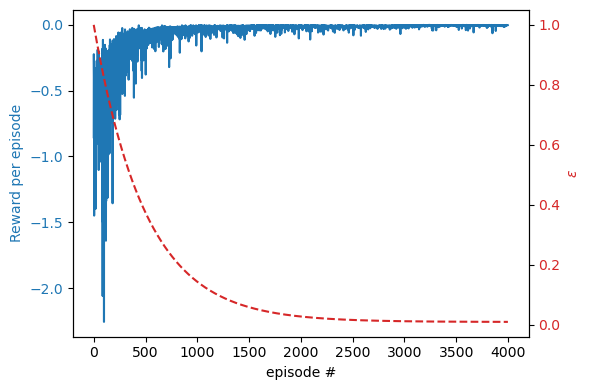

In [30]:
# final episode rewards
fig, ax1 = plt.subplots(dpi=100)
color = 'tab:blue'
ax1.set_xlabel('episode #')
ax1.set_ylabel('Reward per episode', color=color)
ax1.plot(episode_rewards[:-1], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$\epsilon$', color=color)
ax2.plot(epsilon, color=color, linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

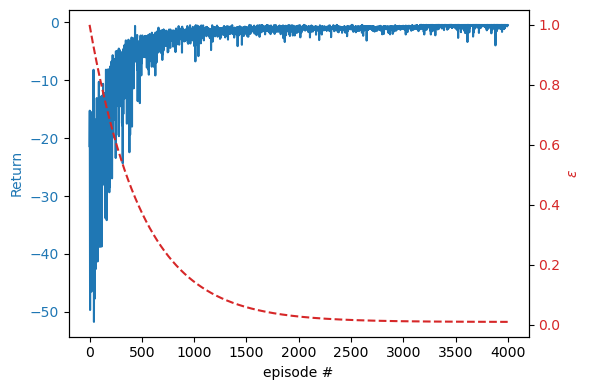

In [29]:
# episode returns (summed up rewards)
fig, ax1 = plt.subplots(dpi=100)
color = 'tab:blue'
ax1.set_xlabel('episode #')
ax1.set_ylabel('Return', color=color)
ax1.plot(returns, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(r'$\epsilon$', color=color)
ax2.plot(epsilon, color=color, linestyle="--")
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()

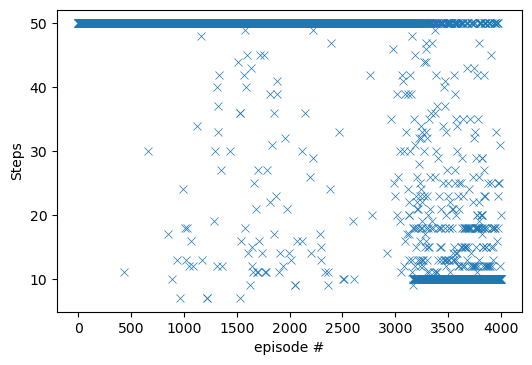

In [22]:
# Number of episode steps during training
fig = plt.figure(dpi=100)
plt.plot(episode_steps, 'x', markeredgewidth=0.5)
plt.xlabel('episode #')
plt.ylabel('Steps');

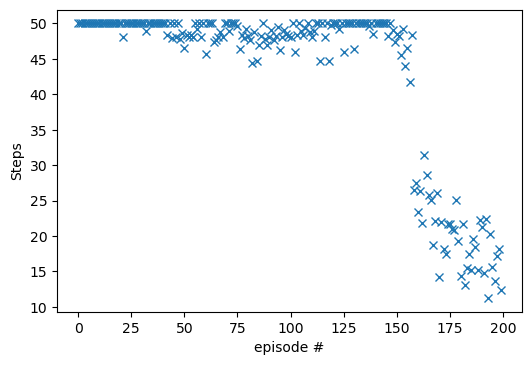

In [28]:
# Averaged number of episode steps during training
skip = 20
steps = np.mean(np.array(episode_steps).reshape(-1, skip), axis=1)
fig = plt.figure(dpi=100)
plt.plot(steps, 'x')
plt.xlabel('episode #')
plt.ylabel('Steps');